In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr


from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.linear_model import Lasso

In [ ]:
## To do
- get the features listed below
- plot the different square feet things together to see what the relationship is
    - land square feet
    - gross square feet
    - zillow square feet
- try the regression with and without zillow median price
- clean up building_class_category
- run regression
- try feature engineering/scaling

## Model

y - sale price

### Features 
- residential units (done)
- commercial units
- land_square_feet
- gross_square_feet
- zillow square feet
- year_built
- building_class_category (CATEGORY)
- neighborhood OR zip code (CATEGORY)
- time - optional (CATEGORY - grab either month or year)


To Do¶ NEWEST 
-statsmodels OLS - betas and p's
-see if you can do some feature engineering then repeat ^
    -log, square, cube, square root, etc.
    -interaction terms for dummy variables
-do your cross validation stuff (tues + weds)
-then maybe regularization (ridge & lassso) (refer to sean's code)

                                             
                                             #to do
###newdfclean
#Other data to get, public transportation, income by,  crime by 
#categorial: boro, tax code by class, zip-code,
# data= data[data['TAX_CLASS_AT_TIME_OF_SALE'] == 1 or 2]

In [2]:
data=pd.read_excel("rollingsales_manhattan.xls", skiprows=1) #combined excel sheets for 2016-2018

data = data[data['SALE_PRICE'] > 90000] #get rid of 0's in sale price 
data = data[data['SALE_PRICE'] < 50000000] #get rid of 0's in sale price 
data=data[data['GROSS SQUARE FEET'] > 100] #get rid of 0s in square foot
data.columns=['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE']
zillow_squarefootage=pd.read_excel("Zip_MedianListingPricePerSqft_AllHomes.xls")
zillow_squarefootage=zillow_squarefootage.loc[:,["RegionName","2018-10"]] 
zillow_squarefootage['ZIP_CODE']=zillow_squarefootage['RegionName']
zillow_squarefootage['ZillowSquareFootage']=zillow_squarefootage['2018-10']

zillow_median_listing=pd.read_excel("Zip_MedianListingPrice_AllHomes.xls")
zillow_median_listing=zillow_median_listing.loc[:,["RegionName","2018-10"]] 
zillow_median_listing['ZIP_CODE']=zillow_median_listing['RegionName']
zillow_median_listing['ZillowMedianPrice']=zillow_median_listing['2018-10']

new_df2= zillow_squarefootage.merge(zillow_median_listing, how = 'inner', on = ['ZIP_CODE'])
# new_df3=new_df2.merge(average_by_zip_2018, how = 'inner', on = ['ZIP_CODE'])
new_df3= data.merge(new_df2, how = 'inner', on = ['ZIP_CODE'])
new_df=new_df3.copy()
new_df=new_df.drop(columns=['RegionName_y', 'RegionName_x',"2018-10_x","2018-10_y"])
# new_df.columns

In [6]:
#Changing the datatype of Median Price and Square Footage from Float to Integer
new_df['ZillowMedianPrice'] = new_df['ZillowMedianPrice'].astype(int)
new_df['ZillowSquareFootage'] = new_df['ZillowSquareFootage'].astype(int)
target=new_df[["SALE_PRICE"]]
features= new_df 

features=features.drop(columns=["NEIGHBORHOOD","SALE_DATE",'BOROUGH',                     
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 
        'TOTAL_UNITS',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
      'SALE_PRICE']) #maybe drop zillow two 
features["BUILDING_CLASS_CATEGORY"]=features["BUILDING_CLASS_CATEGORY"].str.strip()
features["BUILDING_CLASS_CATEGORY"]=features["BUILDING_CLASS_CATEGORY"].str.replace(' ', '')
#Strip duplicate neighborhood categories
# features["NEIGHBORHOOD"]=features["NEIGHBORHOOD"].str.strip()
# features["NEIGHBORHOOD"]=features["NEIGHBORHOOD"].str.replace(' ', '')
cat_vars=features[['BUILDING_CLASS_CATEGORY',"ZIP_CODE"]]
#log transform the target 
new_df["SALE_PRICE"] = np.log1p(new_df["SALE_PRICE"])
new_df["BUILDING_CLASS_CATEGORY"]=new_df["BUILDING_CLASS_CATEGORY"].str.strip()
new_df["BUILDING_CLASS_CATEGORY"]=new_df["BUILDING_CLASS_CATEGORY"].str.replace(' ', '')

In [7]:
#create dummies
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(features[var], prefix=var,drop_first=True)
    data1=features.join(cat_list)
    features=data1
data_vars=features.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
features=features[to_keep]


/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


skewness: -1.165057
kurtosis: 0.426279


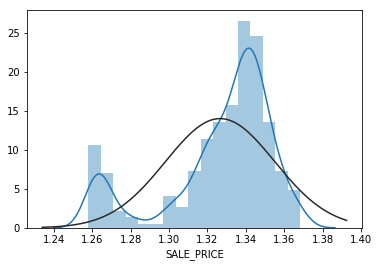

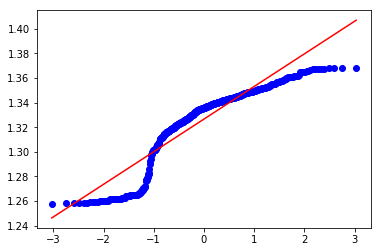

In [10]:
#Plotting the Sale Price Distribution 
#notes
#Plotted the distribution of the SALE_PRICE and normal probability graph which is used to identify substantive departures from normality. 
# This includes identifying outliers, skewness and kurtosis.


new_df["SALE_PRICE"].describe()
sns.distplot(new_df.SALE_PRICE,fit=norm);
plt.ylabel =('Frequency')
plt.title = ('SalePrice Distribution');
#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(new_df["SALE_PRICE"]);
#QQ plot
fig = plt.figure()
res = stats.probplot(new_df["SALE_PRICE"], plot=plt)
# plt.show()
print("skewness: %f" % new_df["SALE_PRICE"].skew())
print("kurtosis: %f" % new_df["SALE_PRICE"].kurt())

/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'House Sales Price in USD(LOG)')

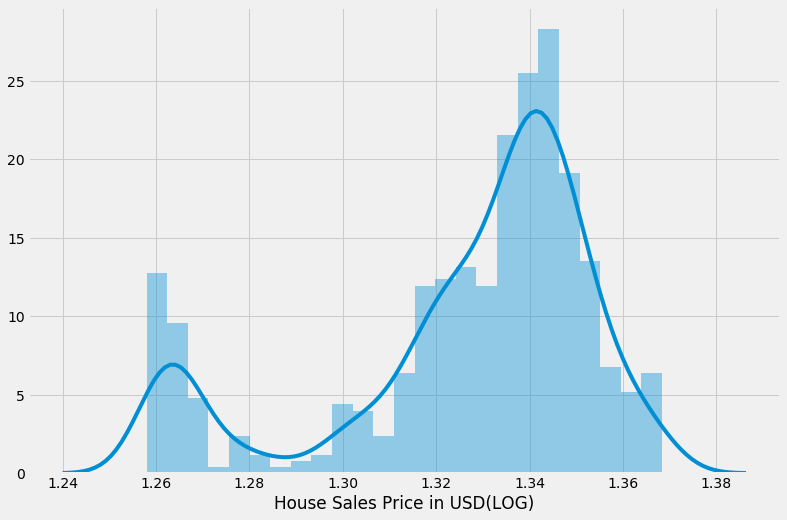

In [63]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.distplot(new_df.SALE_PRICE, bins = 25)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1))
plt.xlabel("House Sales Price in USD(LOG)")
# plt.ylabel("Number of Houses")
# plt.title("House Sales Price Distribution")

# # Step 1: Checking for Linearity  using Scatterplots

/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


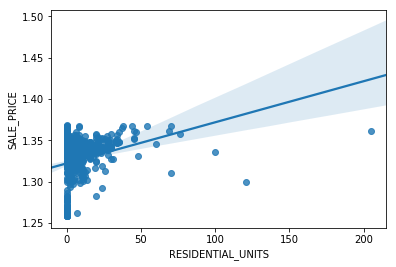

In [11]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['RESIDENTIAL_UNITS'], data=new_df, fit_reg = True)

/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


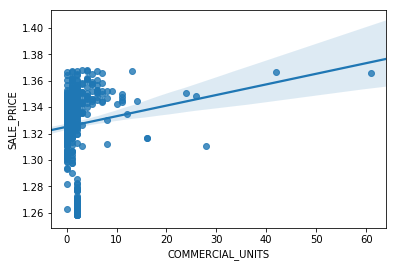

In [12]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['COMMERCIAL_UNITS'], data=new_df, fit_reg = True)


/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


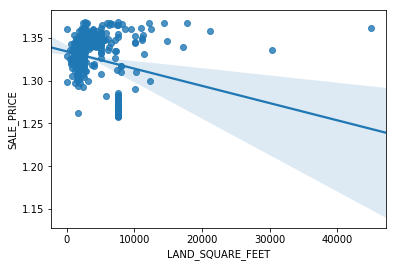

In [13]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['LAND_SQUARE_FEET'], data=new_df, fit_reg = True)

/Users/powersky/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


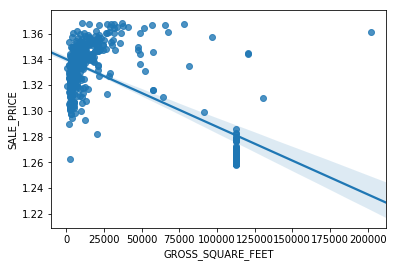

In [14]:
sns.regplot(y=new_df.SALE_PRICE, x=new_df['GROSS_SQUARE_FEET'], data=new_df, fit_reg = True)

# Graph showing the distribution of prices by Zip-Code

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

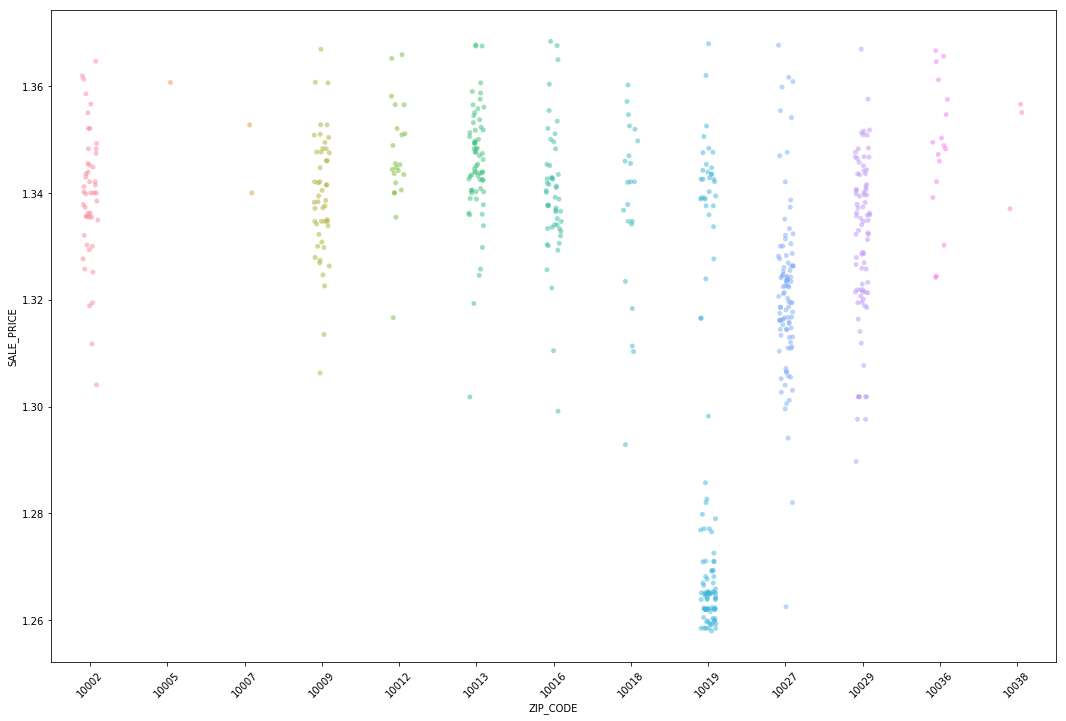

In [22]:
plt.figure(figsize=(18,12))
sns.stripplot(x = new_df.ZIP_CODE, y = new_df.SALE_PRICE,
              order = np.sort(new_df.ZIP_CODE.unique()),
              jitter=0.1, alpha=0.5)
plt.xticks(rotation=45)

# Distribution of square footage and sale price

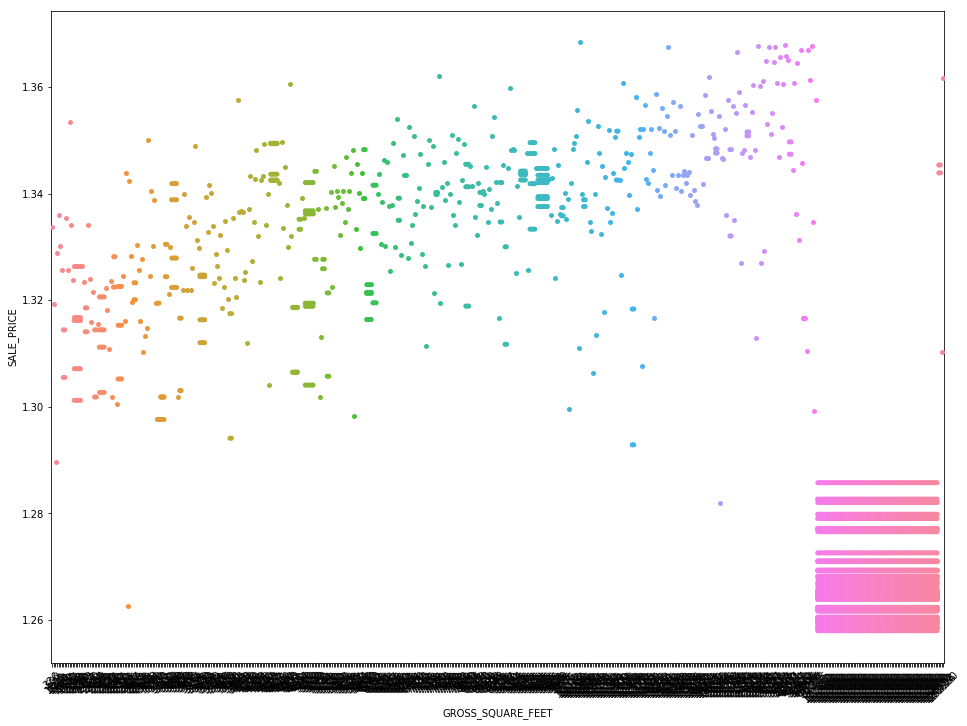

In [23]:
plt.figure(figsize=(16,12))
plt.xticks(rotation=45)
sns.stripplot(x = new_df.GROSS_SQUARE_FEET, y = new_df.SALE_PRICE,
              order = np.sort(new_df.GROSS_SQUARE_FEET),
              jitter=0.1, alpha=1)


# Regression Info Below
# Features described first 

# Of the 6 original features used [RESIDENTIAL_UNITS, COMMERCIAL_UNITS, LAND_SQUARE_FEET, GROSS_SQUARE_FEET, ZillowSquareFootage and ZillowMedianPrice], only the LAND_SQUARE_FEET had a P value above 0.05. Its value was 0.219

# R^2 total using 4 features = 0.679 

In [24]:
m7 = ols('SALE_PRICE ~RESIDENTIAL_UNITS+COMMERCIAL_UNITS+GROSS_SQUARE_FEET+ZillowSquareFootage+ ZillowMedianPrice',new_df).fit()
print(m7.summary())
m1 = ols('SALE_PRICE ~GROSS_SQUARE_FEET',new_df).fit()
print(m1.summary())
m2 = ols('SALE_PRICE ~RESIDENTIAL_UNITS ',new_df).fit()
print(m2.summary())
m3 = ols('SALE_PRICE ~COMMERCIAL_UNITS ',new_df).fit()
print(m3.summary())
m5 = ols('SALE_PRICE ~GROSS_SQUARE_FEET ',new_df).fit()
print(m5.summary())



# #####regression for zillow items below 
# m8 = ols('SALE_PRICE ~ZillowSquareFootage ',new_df).fit()
# print(m8.summary())
# m9 = ols('SALE_PRICE ~ZillowMedianPrice ',new_df).fit()
# print(m9.summary())
# m10 = ols('SALE_PRICE ~RESIDENTIAL_UNITS+ZillowSquareFootage+ZillowMedianPrice+COMMERCIAL_UNITS+LAND_SQUARE_FEET+GROSS_SQUARE_FEET+YEAR_BUILT ',new_df).fit()
# print(m10.summary())



                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     282.8
Date:                Fri, 07 Dec 2018   Prob (F-statistic):          8.01e-151
Time:                        12:10:16   Log-Likelihood:                 1573.0
No. Observations:                 568   AIC:                            -3134.
Df Residuals:                     562   BIC:                            -3108.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.3089    

In [25]:
reg = LinearRegression()

In [26]:
train1= features # can change to scaled_features or features to test regresion model with or without categorical values 
labels=new_df["SALE_PRICE"] 

In [27]:
# x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.20,random_state =10)
X_train, X_test, y_train, y_test = train_test_split(train1, labels, random_state=32,test_size=0.2)

In [28]:
reg.fit(X_train,y_train)
reg.score(X_test,y_test) 
#highest score with all variables (2110) is .79

0.7453998031191021

# #We create a scatterplot between the predicted prices, (where m is the fitted model) and the original prices. 

# A perfect model would get us a scatterplot where all the data lies on the 45 degree line. 

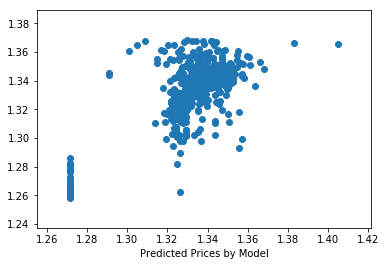

In [29]:
predicted_prices = m7.fittedvalues

plt.scatter(predicted_prices, new_df.SALE_PRICE)
plt.xlabel("Predicted Prices by Model")
plt.ylabel='Original Prices'
plt.title='Predictions vs. Original Prices'
plt.show()

Text(0.5, 0, 'Fitted Values')

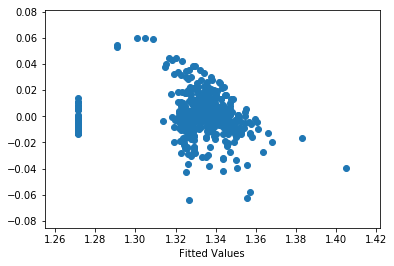

In [31]:
#Resid?
x = m7.fittedvalues
y = m7.resid
plt.scatter(x, y)
plt.xlabel("Fitted Values")

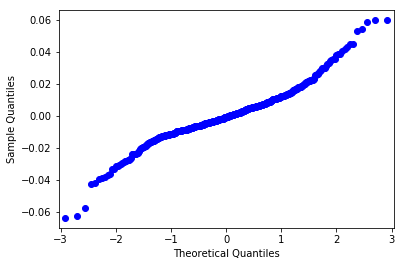

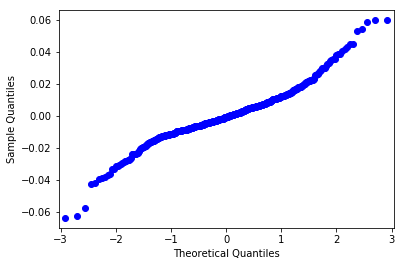

In [32]:
sm.qqplot(m7.resid)

In [33]:
lm = LinearRegression()

In [34]:
lm.fit(X_train,y_train)

# evaluation using r-square

lm.score(X_train,y_train)
y_pred = lm.predict(X_test)

# MSE AND RMSE are below 1 largely due to the fact that the log function was used on the sale prices 

In [36]:
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MSE: 0.00022037317392205343
RMSE: 0.014844971334497532


In [37]:
from sklearn.metrics import median_absolute_error
median_absolute_error(y_test, y_pred)
# sklearn.metrics.median_absolute_error(y_true, y_pred)[source]

0.006935329849741656

In [97]:
# X_test=x_test
# X_train=x_train
lm = LinearRegression()
lm.fit(X_train,y_train)

# evaluation using r-square

lm.score(X_train,y_train)
y_pred = lm.predict(X_test)


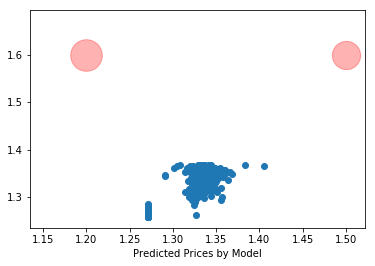

In [55]:
plt.scatter(1.2, 1.6, s=1000, alpha=0.3, c = 'r' )
plt.scatter(1.5, 1.6, s=800, alpha=0.3, c = 'r' )
predicted_prices = m7.fittedvalues

plt.xlabel("Predicted Prices by Model")
# plt.ylabel()
# plt.title("Predictions vs. Original Prices")
plt.scatter(predicted_prices, new_df.SALE_PRICE)

In [57]:
\

In [ ]:
# x_test

In [65]:
from sklearn import preprocessing
from sklearn import pipeline

scaler = preprocessing.StandardScaler()


In [66]:
scaler.fit(features.iloc[:,:-1])


/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [67]:
len(X_test1.columns[:-1])
len(X_test1.iloc[:,:-1])
X_test1.columns.shape

NameError: name 'X_test1' is not defined

In [68]:
scaler.fit(X_train.iloc[:,:-1])
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,:-1]), columns=X_train.columns[:-1], index=X_train.index)

features_scaled_train.head()

/Users/powersky/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/powersky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,ZillowSquareFootage,ZillowMedianPrice,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,...,ZIP_CODE_10007,ZIP_CODE_10009,ZIP_CODE_10012,ZIP_CODE_10013,ZIP_CODE_10016,ZIP_CODE_10018,ZIP_CODE_10019,ZIP_CODE_10027,ZIP_CODE_10029,ZIP_CODE_10036
408,-0.441441,-0.533787,-0.492679,-0.592616,1.636723,-0.964423,-0.899554,-0.220225,5.232112,-0.791985,...,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,-0.197235,-0.490344,-0.458984,2.403356,-0.178377
298,0.944099,-0.533787,-0.365512,-0.411689,-0.277130,0.311053,-0.061024,-0.220225,-0.191127,1.262650,...,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,-0.197235,2.039385,-0.458984,-0.416085,-0.178377
282,-0.685949,-0.219876,0.444324,0.304423,0.617658,0.311053,-0.061024,-0.220225,-0.191127,-0.791985,...,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,-0.197235,2.039385,-0.458984,-0.416085,-0.178377
199,-0.359939,0.094035,-0.333639,-0.496858,-0.774235,1.043086,-0.215902,-0.220225,-0.191127,-0.791985,...,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,-0.197235,-0.490344,-0.458984,-0.416085,-0.178377
307,0.944099,-0.533787,-0.365512,-0.407606,-0.277130,0.311053,-0.061024,-0.220225,-0.191127,1.262650,...,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,-0.197235,2.039385,-0.458984,-0.416085,-0.178377


In [69]:
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,:-1]), columns=X_test.columns[:-1], index=X_test.index)

features_scaled_test.head()

/Users/powersky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,ZillowSquareFootage,ZillowMedianPrice,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,...,ZIP_CODE_10007,ZIP_CODE_10009,ZIP_CODE_10012,ZIP_CODE_10013,ZIP_CODE_10016,ZIP_CODE_10018,ZIP_CODE_10019,ZIP_CODE_10027,ZIP_CODE_10029,ZIP_CODE_10036
216,0.944099,0.094035,-0.031821,-0.044637,2.034407,1.043086,-0.215902,-0.220225,-0.191127,-0.791985,...,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,-0.197235,-0.490344,-0.458984,-0.416085,-0.178377
440,0.618090,-0.533787,-0.361284,-0.492068,-0.774235,-0.964423,-0.899554,-0.220225,-0.191127,1.262650,...,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,-0.197235,-0.490344,-0.458984,2.403356,-0.178377
270,9.175841,-0.533787,2.832527,1.825736,0.592803,-0.425944,-0.349399,-0.220225,-0.191127,-0.791985,...,-0.066519,-0.302235,-0.191127,-0.35574,3.217142,-0.197235,-0.490344,-0.458984,-0.416085,-0.178377
16,1.270109,-0.533787,-0.380148,-0.332644,-0.774235,1.931452,1.681742,-0.220225,-0.191127,1.262650,...,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,5.070097,-0.490344,-0.458984,-0.416085,-0.178377
483,-0.441441,-0.533787,-0.528130,-0.580040,-0.799091,1.618787,1.290636,-0.220225,5.232112,-0.791985,...,-0.066519,-0.302235,5.232112,-0.35574,-0.310835,-0.197235,-0.490344,-0.458984,-0.416085,-0.178377


In [70]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_64_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
features_64_train.head()


,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,ZillowSquareFootage,ZillowMedianPrice,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,...,ZIP_CODE_10019^2,ZIP_CODE_10019 ZIP_CODE_10027,ZIP_CODE_10019 ZIP_CODE_10029,ZIP_CODE_10019 ZIP_CODE_10036,ZIP_CODE_10027^2,ZIP_CODE_10027 ZIP_CODE_10029,ZIP_CODE_10027 ZIP_CODE_10036,ZIP_CODE_10029^2,ZIP_CODE_10029 ZIP_CODE_10036,ZIP_CODE_10036^2
0,-0.441441,-0.533787,-0.492679,-0.592616,1.636723,-0.964423,-0.899554,-0.220225,5.232112,-0.791985,...,0.240437,0.225060,-1.178471,0.087466,0.210667,-1.103103,0.081872,5.776119,-0.428702,0.031818
1,0.944099,-0.533787,-0.365512,-0.411689,-0.277130,0.311053,-0.061024,-0.220225,-0.191127,1.262650,...,4.159091,-0.936046,-0.848557,-0.363778,0.210667,0.190976,0.081872,0.173127,0.074220,0.031818
2,-0.685949,-0.219876,0.444324,0.304423,0.617658,0.311053,-0.061024,-0.220225,-0.191127,-0.791985,...,4.159091,-0.936046,-0.848557,-0.363778,0.210667,0.190976,0.081872,0.173127,0.074220,0.031818
3,-0.359939,0.094035,-0.333639,-0.496858,-0.774235,1.043086,-0.215902,-0.220225,-0.191127,-0.791985,...,0.240437,0.225060,0.204025,0.087466,0.210667,0.190976,0.081872,0.173127,0.074220,0.031818
4,0.944099,-0.533787,-0.365512,-0.407606,-0.277130,0.311053,-0.061024,-0.220225,-0.191127,1.262650,...,4.159091,-0.936046,-0.848557,-0.363778,0.210667,0.190976,0.081872,0.173127,0.074220,0.031818


In [71]:
pd.set_option('display.max_columns', 100)
features_64_train.head()
features_64_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))
features_64_test.head()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,ZillowSquareFootage,ZillowMedianPrice,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_10COOPS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT,BUILDING_CLASS_CATEGORY_17CONDOCOOPS,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER,ZIP_CODE_10005,ZIP_CODE_10007,ZIP_CODE_10009,ZIP_CODE_10012,ZIP_CODE_10013,ZIP_CODE_10016,ZIP_CODE_10018,ZIP_CODE_10019,ZIP_CODE_10027,ZIP_CODE_10029,ZIP_CODE_10036,RESIDENTIAL_UNITS^2,RESIDENTIAL_UNITS COMMERCIAL_UNITS,RESIDENTIAL_UNITS LAND_SQUARE_FEET,RESIDENTIAL_UNITS GROSS_SQUARE_FEET,RESIDENTIAL_UNITS YEAR_BUILT,RESIDENTIAL_UNITS ZillowSquareFootage,RESIDENTIAL_UNITS ZillowMedianPrice,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,...,ZIP_CODE_10007 ZIP_CODE_10018,ZIP_CODE_10007 ZIP_CODE_10019,ZIP_CODE_10007 ZIP_CODE_10027,ZIP_CODE_10007 ZIP_CODE_10029,ZIP_CODE_10007 ZIP_CODE_10036,ZIP_CODE_10009^2,ZIP_CODE_10009 ZIP_CODE_10012,ZIP_CODE_10009 ZIP_CODE_10013,ZIP_CODE_10009 ZIP_CODE_10016,ZIP_CODE_10009 ZIP_CODE_10018,ZIP_CODE_10009 ZIP_CODE_10019,ZIP_CODE_10009 ZIP_CODE_10027,ZIP_CODE_10009 ZIP_CODE_10029,ZIP_CODE_10009 ZIP_CODE_10036,ZIP_CODE_10012^2,ZIP_CODE_10012 ZIP_CODE_10013,ZIP_CODE_10012 ZIP_CODE_10016,ZIP_CODE_10012 ZIP_CODE_10018,ZIP_CODE_10012 ZIP_CODE_10019,ZIP_CODE_10012 ZIP_CODE_10027,ZIP_CODE_10012 ZIP_CODE_10029,ZIP_CODE_10012 ZIP_CODE_10036,ZIP_CODE_10013^2,ZIP_CODE_10013 ZIP_CODE_10016,ZIP_CODE_10013 ZIP_CODE_10018,ZIP_CODE_10013 ZIP_CODE_10019,ZIP_CODE_10013 ZIP_CODE_10027,ZIP_CODE_10013 ZIP_CODE_10029,ZIP_CODE_10013 ZIP_CODE_10036,ZIP_CODE_10016^2,ZIP_CODE_10016 ZIP_CODE_10018,ZIP_CODE_10016 ZIP_CODE_10019,ZIP_CODE_10016 ZIP_CODE_10027,ZIP_CODE_10016 ZIP_CODE_10029,ZIP_CODE_10016 ZIP_CODE_10036,ZIP_CODE_10018^2,ZIP_CODE_10018 ZIP_CODE_10019,ZIP_CODE_10018 ZIP_CODE_10027,ZIP_CODE_10018 ZIP_CODE_10029,ZIP_CODE_10018 ZIP_CODE_10036,ZIP_CODE_10019^2,ZIP_CODE_10019 ZIP_CODE_10027,ZIP_CODE_10019 ZIP_CODE_10029,ZIP_CODE_10019 ZIP_CODE_10036,ZIP_CODE_10027^2,ZIP_CODE_10027 ZIP_CODE_10029,ZIP_CODE_10027 ZIP_CODE_10036,ZIP_CODE_10029^2,ZIP_CODE_10029 ZIP_CODE_10036,ZIP_CODE_10036^2
0,0.944099,0.094035,-0.031821,-0.044637,2.034407,1.043086,-0.215902,-0.220225,-0.191127,-0.791985,4.658326,0.0,-0.081559,-0.284521,-0.046984,-0.275371,-0.270714,-0.171693,-0.046984,-0.405096,-0.081559,-0.046984,-0.046984,-0.081559,-0.046984,-0.046984,-0.157578,-0.046984,-0.066519,-0.046984,-0.066519,-0.302235,-0.191127,-0.35574,-0.310835,-0.197235,-0.490344,-0.458984,-0.416085,-0.178377,0.891324,0.088778,-0.030042,-0.042142,1.920682,0.984777,-0.203833,-0.207914,-0.180443,-0.747712,...,0.013120,0.032617,0.030531,0.027678,0.011865,0.091346,0.057765,0.107517,0.093945,0.059611,0.148199,0.138721,0.125756,0.053912,0.03653,0.067992,0.059409,0.037697,0.093718,0.087724,0.079525,0.034093,0.126551,0.110576,0.070164,0.174435,0.163279,0.148018,0.063456,0.096618,0.061307,0.152416,0.142668,0.129334,0.055446,0.038902,0.096713,0.090528,0.082066,0.035182,0.240437,0.22506,0.204025,0.087466,0.210667,0.190976,0.081872,0.173127,0.074220,0.031818
1

In [72]:
# ***

In [73]:
from sklearn.feature_selection import VarianceThreshold
thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [74]:
features_selected_train = variance_threshold_selector(features_64_train)
# features_selected_train = variance_threshold_selector(features_64_train)

In [75]:
from sklearn.feature_selection import RFE
rfe = RFE(lm, n_features_to_select=10)
rfe.fit(features_selected_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=10, step=1, verbose=0)

In [76]:
features_selected_train.head()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,ZillowSquareFootage,ZillowMedianPrice,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT,BUILDING_CLASS_CATEGORY_17CONDOCOOPS,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER,ZIP_CODE_10005,ZIP_CODE_10007,ZIP_CODE_10009,ZIP_CODE_10012,ZIP_CODE_10013,ZIP_CODE_10016,ZIP_CODE_10018,ZIP_CODE_10019,ZIP_CODE_10027,ZIP_CODE_10029,ZIP_CODE_10036,RESIDENTIAL_UNITS^2,RESIDENTIAL_UNITS COMMERCIAL_UNITS,RESIDENTIAL_UNITS LAND_SQUARE_FEET,RESIDENTIAL_UNITS GROSS_SQUARE_FEET,RESIDENTIAL_UNITS YEAR_BUILT,RESIDENTIAL_UNITS ZillowSquareFootage,RESIDENTIAL_UNITS ZillowMedianPrice,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_17CONDOCOOPS,...,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS ZIP_CODE_10019,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS^2,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS ZIP_CODE_10007,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS ZIP_CODE_10012,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS ZIP_CODE_10013,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS ZIP_CODE_10018,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS^2,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS ZIP_CODE_10018,BUILDING_CLASS_CATEGORY_26OTHERHOTELS^2,BUILDING_CLASS_CATEGORY_26OTHERHOTELS ZIP_CODE_10005,BUILDING_CLASS_CATEGORY_26OTHERHOTELS ZIP_CODE_10018,BUILDING_CLASS_CATEGORY_26OTHERHOTELS ZIP_CODE_10019,BUILDING_CLASS_CATEGORY_26OTHERHOTELS ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES^2,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES ZIP_CODE_10018,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_30WAREHOUSES^2,BUILDING_CLASS_CATEGORY_30WAREHOUSES ZIP_CODE_10013,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND^2,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND ZIP_CODE_10009,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES^2,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES ZIP_CODE_10009,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES ZIP_CODE_10019,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES ZIP_CODE_10027,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES^2,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES ZIP_CODE_10027,BUILDING_CLASS_CATEGORY_34THEATRES^2,BUILDING_CLASS_CATEGORY_34THEATRES ZIP_CODE_10009,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES^2,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES ZIP_CODE_10016,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES ZIP_CODE_10027,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES ZIP_CODE_10029,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES^2,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER^2,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER ZIP_CODE_10012,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER ZIP_CODE_10019,ZIP_CODE_10005^2,ZIP_CODE_10007^2,ZIP_CODE_10009^2,ZIP_CODE_10012^2,ZIP_CODE_10013^2,ZIP_CODE_10016^2,ZIP_CODE_10018^2,ZIP_CODE_10019^2,ZIP_CODE_10027^2,ZIP_CODE_10029^2,ZIP_CODE_10036^2
0,-0.441441,-0.533787,-0.492

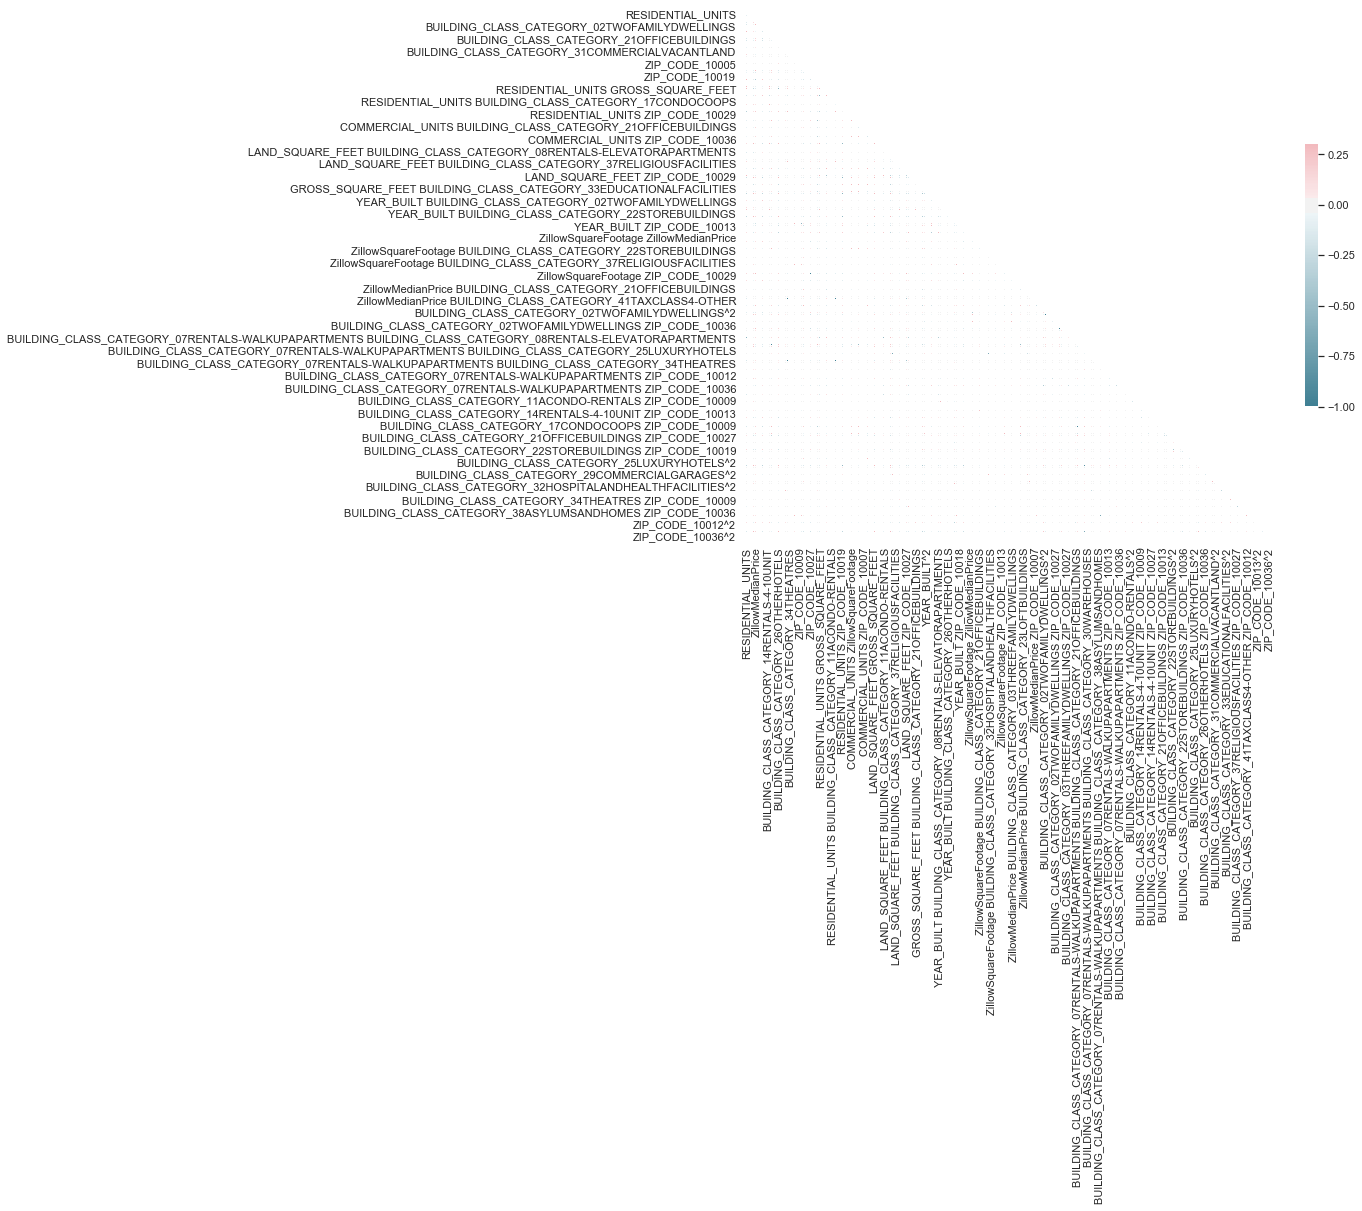

In [77]:
import seaborn as sns

sns.set(style="white")


# Compute the correlation matrix
corr = features_selected_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [78]:
# Create correlation matrix
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [79]:
upper

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,ZillowSquareFootage,ZillowMedianPrice,BUILDING_CLASS_CATEGORY_02TWOFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_03THREEFAMILYDWELLINGS,BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,BUILDING_CLASS_CATEGORY_14RENTALS-4-10UNIT,BUILDING_CLASS_CATEGORY_17CONDOCOOPS,BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS,BUILDING_CLASS_CATEGORY_26OTHERHOTELS,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES,BUILDING_CLASS_CATEGORY_30WAREHOUSES,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES,BUILDING_CLASS_CATEGORY_34THEATRES,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER,ZIP_CODE_10005,ZIP_CODE_10007,ZIP_CODE_10009,ZIP_CODE_10012,ZIP_CODE_10013,ZIP_CODE_10016,ZIP_CODE_10018,ZIP_CODE_10019,ZIP_CODE_10027,ZIP_CODE_10029,ZIP_CODE_10036,RESIDENTIAL_UNITS^2,RESIDENTIAL_UNITS COMMERCIAL_UNITS,RESIDENTIAL_UNITS LAND_SQUARE_FEET,RESIDENTIAL_UNITS GROSS_SQUARE_FEET,RESIDENTIAL_UNITS YEAR_BUILT,RESIDENTIAL_UNITS ZillowSquareFootage,RESIDENTIAL_UNITS ZillowMedianPrice,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_08RENTALS-ELEVATORAPARTMENTS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_11ACONDO-RENTALS,RESIDENTIAL_UNITS BUILDING_CLASS_CATEGORY_17CONDOCOOPS,...,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS ZIP_CODE_10019,BUILDING_CLASS_CATEGORY_22STOREBUILDINGS ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS^2,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS ZIP_CODE_10007,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS ZIP_CODE_10012,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS ZIP_CODE_10013,BUILDING_CLASS_CATEGORY_23LOFTBUILDINGS ZIP_CODE_10018,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS^2,BUILDING_CLASS_CATEGORY_25LUXURYHOTELS ZIP_CODE_10018,BUILDING_CLASS_CATEGORY_26OTHERHOTELS^2,BUILDING_CLASS_CATEGORY_26OTHERHOTELS ZIP_CODE_10005,BUILDING_CLASS_CATEGORY_26OTHERHOTELS ZIP_CODE_10018,BUILDING_CLASS_CATEGORY_26OTHERHOTELS ZIP_CODE_10019,BUILDING_CLASS_CATEGORY_26OTHERHOTELS ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES^2,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES ZIP_CODE_10018,BUILDING_CLASS_CATEGORY_29COMMERCIALGARAGES ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_30WAREHOUSES^2,BUILDING_CLASS_CATEGORY_30WAREHOUSES ZIP_CODE_10013,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND^2,BUILDING_CLASS_CATEGORY_31COMMERCIALVACANTLAND ZIP_CODE_10009,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES^2,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES ZIP_CODE_10009,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES ZIP_CODE_10019,BUILDING_CLASS_CATEGORY_32HOSPITALANDHEALTHFACILITIES ZIP_CODE_10027,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES^2,BUILDING_CLASS_CATEGORY_33EDUCATIONALFACILITIES ZIP_CODE_10027,BUILDING_CLASS_CATEGORY_34THEATRES^2,BUILDING_CLASS_CATEGORY_34THEATRES ZIP_CODE_10009,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES^2,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES ZIP_CODE_10016,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES ZIP_CODE_10027,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES ZIP_CODE_10029,BUILDING_CLASS_CATEGORY_37RELIGIOUSFACILITIES ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES^2,BUILDING_CLASS_CATEGORY_38ASYLUMSANDHOMES ZIP_CODE_10036,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER^2,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER ZIP_CODE_10012,BUILDING_CLASS_CATEGORY_41TAXCLASS4-OTHER ZIP_CODE_10019,ZIP_CODE_10005^2,ZIP_CODE_10007^2,ZIP_CODE_10009^2,ZIP_CODE_10012^2,ZIP_CODE_10013^2,ZIP_CODE_10016^2,ZIP_CODE_10018^2,ZIP_CODE_10019^2,ZIP_CODE_10027^2,ZIP_CODE_10029^2,ZIP_CODE_10036^2
RESIDENTIAL_UNITS,NaN,0.1007

In [80]:
features_selected_train.drop(columns=to_drop, inplace=True)

/Users/powersky/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [99]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [100]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]
test = SelectKBest(score_func=mutual_info_regression, k=30)
fit = test.fit(features_selected_train, y_train)

ValueError: k should be >=0, <= n_features = 5; got 30. Use k='all' to return all features.

In [101]:
features_selected_train[features_selected_train.columns[fit.get_support(indices=True)]].head()

IndexError: index 52 is out of bounds for axis 1 with size 5

In [102]:
features_selected_train = information_selector(features_selected_train, y_train, mutual_info_regression, k=5)

In [103]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train, y_train)

In [104]:
features_selected_test = features_64_test[features_selected_train.columns]
y_pred = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.013648731735304714
0.00042450427675160067
0.020603501565306822


In [105]:
from sklearn.feature_selection import RFE
rfe = RFE(lm, n_features_to_select=10)
rfe.fit(features_selected_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=10, step=1, verbose=0)

In [106]:
def ranking(ranks, names, order=1):

    ranks = map(lambda x: (x,2), ranks)
    return list(sorted(zip(ranks, names),reverse=True))
lm.coef_
features_selected_train.columns[1]

'GROSS_SQUARE_FEET BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS'

In [107]:
rankings = ranking(np.abs(lm.coef_), features_selected_train.columns)

In [108]:
rankings[:15]

[((0.012230089616647646, 2),
  'GROSS_SQUARE_FEET BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS'),
 ((0.01132224689993467, 2), 'GROSS_SQUARE_FEET'),
 ((0.003428688563115896, 2),
  'GROSS_SQUARE_FEET BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS'),
 ((0.0026617326137542666, 2), 'GROSS_SQUARE_FEET ZIP_CODE_10013'),
 ((0.00120950487709086, 2), 'GROSS_SQUARE_FEET ZIP_CODE_10018')]

In [109]:
[item[1] for item in rankings[0:15]]

['GROSS_SQUARE_FEET BUILDING_CLASS_CATEGORY_07RENTALS-WALKUPAPARTMENTS',
 'GROSS_SQUARE_FEET',
 'GROSS_SQUARE_FEET BUILDING_CLASS_CATEGORY_21OFFICEBUILDINGS',
 'GROSS_SQUARE_FEET ZIP_CODE_10013',
 'GROSS_SQUARE_FEET ZIP_CODE_10018']

In [110]:
final_columns = [item[1] for item in rankings[0:15]]


In [111]:
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train[final_columns], y_train)

In [112]:
features_selected_test = features_64_test[final_columns]
y_pred = lm.predict(features_selected_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.01364873173530471
0.0004245042767516
0.020603501565306805


In [ ]:
#look at each distribtions, graph them all 

In [ ]:
model.summary() #y variale is 799.36

In [ ]:
### Module 2 Projects

Projects are designed to review the material we covered in Module 2:

* cleaning data with numpy and pandas
* probability and combinatorics
* probability distributions
* hypothesis testing
* simple linear regression
* multiple linear regression
* cross validation and the bias/variance tradeoff

Ask a main question with which you can use a regression to answer. The other topics we learned in Module 2 can be used as further justification for your answers to subsequent questions.

Sample Questions:

* What best determines the final auction price of an item?
* What are the key factors in determining a country's happiness level?
* Is there a way we can predict the spread of a football game?


### Data
* You must have at least 4 different features in your models (independent variables) with at least one target (dependent variable).
* Your data must contain at least one categorical feature and at least one numerical feature
* **BONUS**: Challenge yourself to obtain a unique dataset (either from webscraping or querying APIs)

### The Deliverables

1. ** A well documented Jupyter Notebook** containing any code you've written for this project, comments explaining it, and graphical visualizations.

## Requirements

#### Organization/Code Cleanliness

* The notebook should be well organized, easy to follow,  and code should be commented where appropriate.  
    * Level Up: The notebook contains well-formatted, professional looking markdown cells explaining any substantial code. All functions have docstrings that act as professional-quality documentation
* The notebook is written for a technical audiences with a way to both understand your approach and reproduce your results. The target audience for this deliverable is other data scientists looking to validate your findings.

#### Visualizations & EDA (Exploratory Data Analysis)

* Your project contains at least 4 _meaningful_ data visualizations, with corresponding interpretations. All visualizations are well labeled with axes labels, a title, and a legend (when appropriate)  
* You pose at least 3 meaningful questions and answer them through EDA.  These questions should be well labeled and easy to identify inside the notebook.
    * **Level Up**: Each question is clearly answered with a visualization that makes the answer easy to understand.   
* Your notebook should contain 1 - 2 paragraphs briefly explaining your approach to this project.


#### Model Quality/Approach

* Your model should not include any predictors with p-values greater than .05 (unless you can justify)
* Your model should have cross-validation and account for the bias-variance tradeoff  
* Your notebook shows an iterative approach to modeling, and details the parameters and results of the model at each iteration.  
    * **Level Up**: Whenever necessary, you briefly explain the changes made from one iteration to the next, and why you made these choices.  
* You provide at least 1 paragraph explaining your final model.   